In [20]:
#!/usr/bin/env python3

from env.MjEnv import MjEnv
import numpy as np
from matplotlib import pyplot as plt

# create and prepare the mujoco instance
mj = MjEnv(noload=True)
mj.testing_xmls = 0
mj.task_reload_chance = -1

# turn on automatic finding of highest stable timestep
mj.mj.set.auto_set_timestep = True

# set finger stiffness algorithm
mj.mj.set.finger_stiffness = -100 # hardcoded real data convergence
# mj.mj.set.finger_stiffness = -0.5 # original model based on linear bending
mj.mj.set.finger_stiffness = -5.5 # new attempt at theory, equating angles 

# define the names of the object sets we want to investigate
object_set_folder = "free_first_joint"
object_sets = [
  "set_test_seg5",
  # "set_test_seg6",
  # "set_test_seg7",
  # "set_test_seg8",
  # "set_test_seg9",
  "set_test_seg10",
  # "set_test_seg15",
  # "set_test_seg20",
  # "set_test_seg25",
  "set_test_seg30"
]

# # uncomment for FULL evaluation
object_sets = [
  "set_test_seg5",
  "set_test_seg6",
  "set_test_seg7",
  "set_test_seg8",
  "set_test_seg9",
  "set_test_seg10",
  "set_test_seg12",
  "set_test_seg14",
  "set_test_seg15",
  "set_test_seg16",
  "set_test_seg18",
  "set_test_seg20",
  "set_test_seg22",
  "set_test_seg24",
  "set_test_seg25",
  "set_test_seg26",
  "set_test_seg28",
  "set_test_seg30"
]

# initialise/wipe variables
data = []
num_sets = len(object_sets)

In [21]:
# OLD, this FEA data uses newtons not grams

# from FEA_data import FEA_1N, FEA_2N, FEA_3N, FEA_4N, FEA_5N

# # this data uses FORCES, it is [1N, 2N, 3N, 4N, 5N]
# FEA_xy = [
#   1e-3 * np.array(FEA_1N),
#   1e-3 * np.array(FEA_2N),
#   1e-3 * np.array(FEA_3N),
#   1e-3 * np.array(FEA_4N),
#   1e-3 * np.array(FEA_5N)]

In [22]:
from FEA_data import fea_data

# this data uses MASSES, it is [100g, 200g, 300g, 400g]
FEA_xy2 = [ 
  1e-3 * fea_data[1],
  1e-3 * fea_data[2],
  1e-3 * fea_data[3],
  1e-3 * fea_data[4]
]

In [23]:
from real_data import real_data

# this data uses MASSES, it is [100g, 200g, 300g, 400g]
REAL_xy = [
  1e-3 * real_data[2],
  1e-3 * real_data[4],
  1e-3 * real_data[6],
  1e-3 * real_data[8]
]

In [24]:
# loop through each object set and gather data
done_one = False
for i in range(0, num_sets):

  # if done_one: break

  set_name = object_set_folder + "/" + object_sets[i]
  # mj._load_object_set(name=set_name)
  # mj._load_xml()
  mj.load(object_set_name=set_name)
  # mj.mj.set.mujoco_timestep = mujoco_timesteps[i] * 0.5
  mj.reset(hard=True)

  # run the validation regime
  print("Curve validation running for:", object_sets[i], "\tN is", mj.mj.get_N(), flush=True)
  print_out = False
  finger_data = mj.mj.curve_validation_regime(print_out)
  data.append(finger_data)

  done_one = True

Curve validation running for: set_test_seg5 	N is 5
Curve validation running for: set_test_seg6 	N is 6
Curve validation running for: set_test_seg7 	N is 7
Curve validation running for: set_test_seg8 	N is 8
Curve validation running for: set_test_seg9 	N is 9
Curve validation running for: set_test_seg10 	N is 10
Curve validation running for: set_test_seg12 	N is 12


/home/luke/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


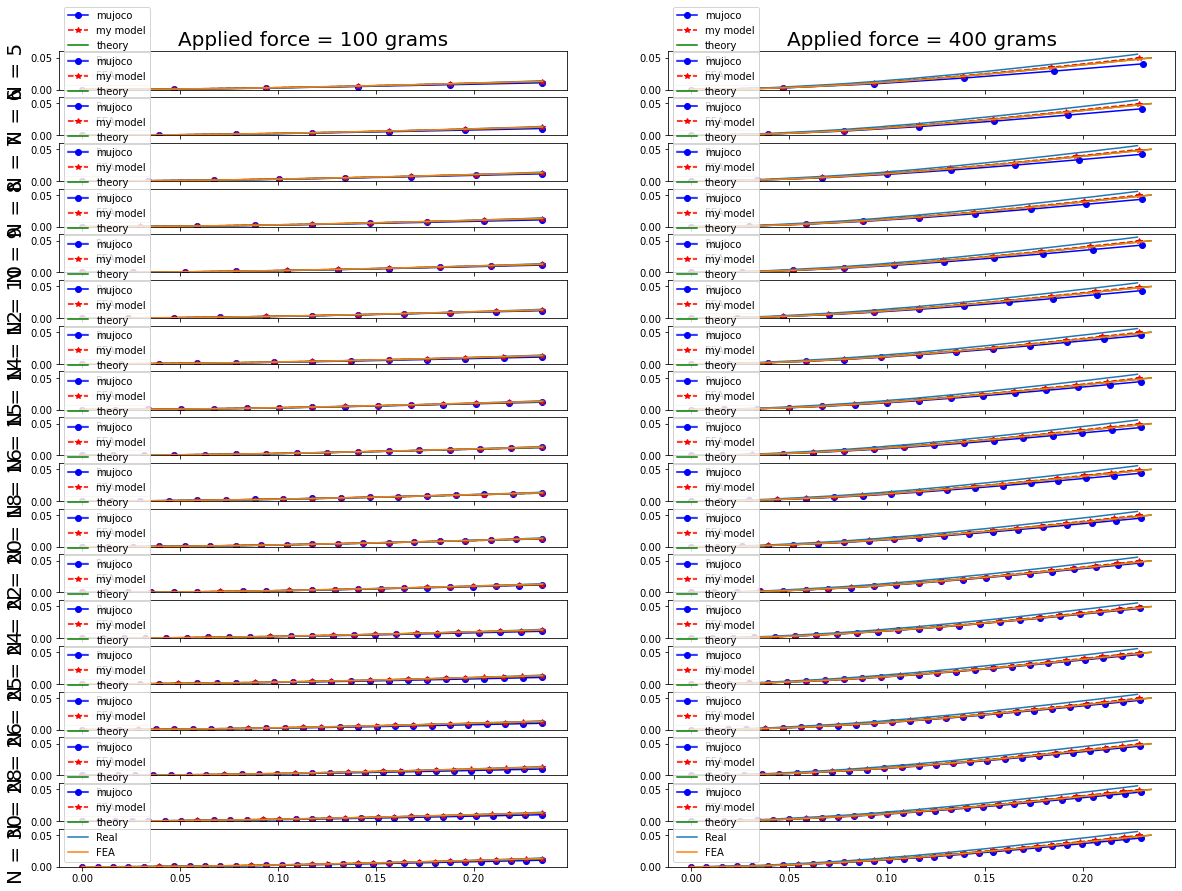

In [ ]:
# now process the data and plot it

entries = list(range(num_sets))
# entries = [0, 5, -1]
entries = [0, 8, -1]

max_force = 4

forces = list(range(1, max_force + 1))
forces = [1, max_force]

fig, axs = plt.subplots(len(entries), len(forces), sharex=True)

for i, force in enumerate(forces):
  for j, ind in enumerate(entries):

    # lets start by plotting a basic example
    x =        np.array(data[ind].entries[force - 1].f1.x)
    y =        np.array(data[ind].entries[force - 1].f1.y)
    pred_x =   np.array(data[ind].entries[force - 1].f1.pred_x)
    pred_y =   np.array(data[ind].entries[force - 1].f1.pred_y)
    theory_x = np.array(data[ind].entries[force - 1].f1.theory_x_curve)
    theory_y = np.array(data[ind].entries[force - 1].f1.theory_y_curve)

    axs[j][i].plot(x,        y,        "b-o",  label="mujoco")
    axs[j][i].plot(pred_x,   pred_y,   "r--*", label="my model")
    axs[j][i].plot(theory_x, theory_y, "g",    label="theory")
    # axs[j][i].plot(FEA_xy[force - 1][:,0], FEA_xy[force - 1][:,1], label="FEA") # this is NEWTONS
    axs[j][i].plot(REAL_xy[force - 1][:,0], REAL_xy[force - 1][:,1], label="Real") # this is GRAMS
    axs[j][i].plot(FEA_xy2[force - 1][:,0], FEA_xy2[force - 1][:,1], label="FEA") # this is GRAMS
    
    temp_N = len(data[ind].entries[force - 1].f1.y) - 1
    # axs[j][i].text(0.005, data[ind].entries[force - 1].f1.theory_y[-1] * 0.4,
    #   f"mujoco stddev wrt model= {1000 * data[ind].entries[force - 1].f1.error.std_y_wrt_pred_y:.2f}mm\n" +
    #   f"mujoco stddev wrt theory = {1000 * data[ind].entries[force - 1].f1.error.std_y_wrt_theory_y:.2f}mm\n" +
    #   f"model stddev wrt theory = {1000 * data[ind].entries[force - 1].f1.error.std_y_pred_wrt_theory_y:.2f}mm",
    #   fontsize=14)
    # axs[j][i].axis("equal")
    axs[j][i].legend()
    axs[j][i].set(ylim=(0, 60e-3))

    if j == 0:
      axs[j][i].set_title(f"Applied force = {force * 100} grams", fontsize=20)
    if i == 0:
      axs[j][i].set_ylabel(f"N = {temp_N}", fontsize=20, rotation=90)

# fig.set_size_inches(35, 25)
fig.set_size_inches(20, 15)
fig.tight_layout()

In [ ]:
print("theory x is", theory_x * 1000)
print("theory y is", theory_y * 1000)

theory x is [  0.           0.           4.89583332   9.79166664  14.68749996
  19.58333328  24.47916567  29.37499993  34.27083045  39.16666657
  44.06249896  48.95833135  53.85416746  58.74999985  63.64583224
  68.5416609   73.43749702  78.33333313  83.2291618   88.12499791
  93.02083403  97.91666269 102.81249881 107.70833492 112.60416359
 117.4999997  122.39582837 127.29166448 132.1875006  137.08332181
 141.97917283 146.87499404 151.77083015 156.66666627 161.56250238
 166.4583236  171.35417461 176.24999583 181.14583194 186.04166806
 190.93750417 195.83332539 200.7291764  205.62499762 210.52083373
 215.41666985 220.31250596 225.20832717 230.10417819 234.9999994 ]
theory y is [0.00000000e+00 0.00000000e+00 3.22596316e-02 1.28136147e-01
 2.86275987e-01 5.05325675e-01 7.83931464e-01 1.12074008e+00
 1.51439768e+00 1.96355116e+00 2.46684626e+00 3.02293012e+00
 3.63044906e+00 4.28804895e+00 4.99437749e+00 5.74807869e+00
 6.54780213e+00 7.39219273e+00 8.27989541e+00 9.20956023e+00
 1.0179830

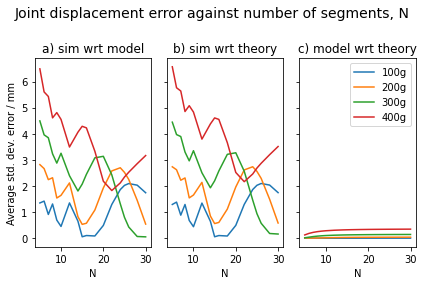

In [ ]:
fig2, axs2 = plt.subplots(1, 3, sharey=True)

# redefine forces to include all, otherwise index error
forces = list(range(1, max_force + 1))

# get std deviation data
dev_y_wrt_pred_y = np.zeros((num_sets, len(forces)))
dev_y_wrt_theory_y = np.zeros((num_sets, len(forces)))
dev_y_pred_wrt_theory_y = np.zeros((num_sets, len(forces)))

labels = ["100g", "200g", "300g", "400g", "500g"]
sets_N = []

for i in range(num_sets):

  sets_N.append(len(data[i].entries[0].f1.y) - 1)

  for j in range(max_force):

    dev_y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.std_y_wrt_pred_y * 1000
    dev_y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.std_y_wrt_theory_y * 1000
    dev_y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.std_y_pred_wrt_theory_y * 1000

axs2[0].plot(np.array(sets_N), dev_y_wrt_pred_y)
axs2[1].plot(np.array(sets_N), dev_y_wrt_theory_y)
lines = axs2[2].plot(np.array(sets_N), dev_y_pred_wrt_theory_y)
plt.legend(iter(lines), labels)

axs2[0].set_title("a) sim wrt model")
axs2[1].set_title("b) sim wrt theory")
axs2[2].set_title("c) model wrt theory")
axs2[0].set(ylabel="Average std. dev. error / mm", xlabel="N")
axs2[1].set(xlabel="N")
axs2[2].set(xlabel="N")
fig2.suptitle("Joint displacement error against number of segments, N", fontsize=14)
fig2.tight_layout()
fig2.subplots_adjust(top=0.8)


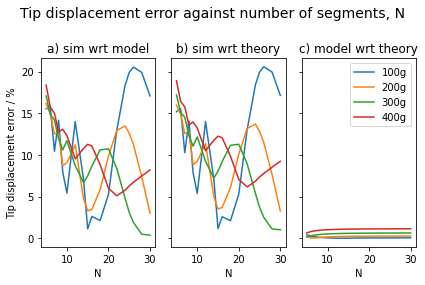

In [ ]:
fig3, axs3 = plt.subplots(1, 3, sharey=True)

# get tip error data
tip_y_wrt_pred_y = np.zeros((num_sets, len(forces)))
tip_y_wrt_theory_y = np.zeros((num_sets, len(forces)))
tip_y_pred_wrt_theory_y = np.zeros((num_sets, len(forces)))

labels = ["100g", "200g", "300g", "400g", "500g"]
sets_N = []

for i in range(num_sets):

  sets_N.append(len(data[i].entries[forces[j] - 1].f1.y) - 1)

  for j in range(len(forces)):

    # # abs value4
    # tip_y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_pred_y * 1000
    # tip_y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_theory_y * 1000
    # tip_y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_pred_tip_wrt_theory_y * 1000

    # percentage
    tip_y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_pred_y_percent * 100
    tip_y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_theory_y_percent * 100
    tip_y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_pred_tip_wrt_theory_y_percent * 100

axs3[0].plot(np.array(sets_N), tip_y_wrt_pred_y)
axs3[1].plot(np.array(sets_N), tip_y_wrt_theory_y)
lines = axs3[2].plot(np.array(sets_N), tip_y_pred_wrt_theory_y)
plt.legend(iter(lines), labels)

axs3[0].set_title("a) sim wrt model")
axs3[1].set_title("b) sim wrt theory")
axs3[2].set_title("c) model wrt theory")
axs3[0].set(ylabel="Tip displacement error / %", xlabel="N")
axs3[1].set(xlabel="N")
axs3[2].set(xlabel="N")
fig3.suptitle("Tip displacement error against number of segments, N", fontsize=14)
fig3.tight_layout()
fig3.subplots_adjust(top=0.8)